In [1]:
#Importando librerías
import numpy as np
import matplotlib.pyplot as plt
import corner #librería para el triangle plot

#from scipy import stats
#import scipy.optimize as opt

In [2]:
#Cargando los datos
A=np.load('fit_exercise.npy')
x=A[0]
y=A[1]
sig=A[2]
sigma=0.05

In [3]:
#parámetros
N=10000 #Número de pasos
c=4 #Número de cadenas

# FUNCIONES

## Funciones del modelo

In [4]:
#Funciones
# funcion del modelo
def f(x, a, b):
    return a + b*x

# Likelihood
def llh(a,b):
    #return -0.5*np.sum((y - f(x, *theta))**2/(sig**2))
    return -0.5*np.sum(np.log(2*np.pi*sig**2)+(y - f(x,a,b))**2/(sig**2))#Con este ya funciona

#por simplicidad defino un prior plano
def prior():
    if sigma <= 0:
        return 0.0
    return 1
    
# Posterior
def p(a,b):
    return llh(a,b)-np.log(prior())

# Generador de muestras
def sample(a,b,tasa):
    a_new=np.random.normal(a, sigma)
    b_new=np.random.normal(b,sigma)
    p_old = p(a,b)
    p_new = p(a_new,b_new)
    if p_new>p_old:
            a=a_new
            b=b_new
            tasa=tasa+1
    else:
            p_accept= p_new - p_old
            accept = np.log(np.random.rand())
            if accept< p_accept:
                a= a_new
                b= b_new
                tasa=tasa+1
   
    return a,b,tasa

#Generador de chain
def cadena(n):
    #Vector donde se guardan las nuevas coordenadas de a y se genera número aleatorio de inicio.
    ap=np.array([np.random.uniform(5, 6)])
    #Vector donde se guardan las nuevas coordenadas de b y se genera número aleatorio de inicio.
    bp=np.array([np.random.uniform(-1, -0.5)])
    #creo una variable para el número de aceptados y la inicilizo en cero 
    acep=0
    for i in range(1,n):
        aux1,aux2,aux3=sample(ap[i-1],bp[i-1],acep)
        ap=np.append(ap,aux1)
        bp=np.append(bp,aux2)
        acep=aux3
    #porcentaje de aceptación
    porc=(acep/n)*100
    return ap,bp,porc

#Está función recibe el número de cadenas y el número de pasos
#En esta función genero una matriz por parámetro, renglos=número de cadena, columnas=num. de pasos
def multicad(ch,l):
    MA=np.empty((ch,l)) #matriz para el parámetro a(independiente)
    MB=np.empty((ch,l)) #matriz para el parámetro b(pendiente)
    PA=np.zeros(ch) #vector para la tasa de aceptación de cada cadena
    for i in range(ch):
        MA[i],MB[i],PA[i]=cadena(l) #lleno cada renglón con los datos que me genera la función cadena
    
    return MA,MB,PA 

## Funciones gráficas

In [5]:
#En esta fucnión genero un grafico donde se puede ver la comparativa entre todos los caminadores...
#... las rectas que generan y su tasa de aceptación.
def cam(A,B,TA):
    print('Parámetro de Gelman-Rubin')
    print('a:',GR(A))
    print('b:',GR(B))
    plt.figure(figsize=(18,6))
    
    plt.subplot(1,3,1)
    for i in range(c):
        plt.plot(A[i],B[i],'.',label='Cadena %s'%(i+1))
        plt.plot(A[i][0],B[i][0],'<')
    plt.legend()
    plt.xlabel('a (ordenada al origen)')
    plt.ylabel('b(pendiente)')
    plt.grid(True)
    
    plt.subplot(1,3,2)
    plt.errorbar(x,y,sig,fmt=".r")
    for i in range (c):
        plt.plot(x,A[i][N-1]+B[i][N-1]*x,'--',label='Cadena %s'%(i+1))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    
    plt.subplot(1,3,3)
    lab=np.arange(1,c+1,1)
    plt.bar(lab,TA)
    plt.title('Aceptación')
    plt.xlabel('Cadena')
    plt.ylabel('Aceptación (%)')
    
    plt.show()
    

In [6]:
def graf(A,B,C):
    #Evoluicon del caminador 
    for i in range (c):
        
        #Datos relevantes por cadena
        sA=A[i].std()
        sB=B[i].std()
        mA=A[i].mean()
        mB=B[i].mean()
        inA=2*sA/np.sqrt(N)
        inB=2*sB/np.sqrt(N)
        
        print('Cadena:',(i+1))
        print('Parámetro a:',mA,'+/-',inA)
        print('Parámetro b:',mB,'+/-',inB)
        print('Tasa de aceptación',C[i],'%')
        
        
        plt.figure(figsize=(15,10))
        plt.subplot(2,1,2)
        plt.plot(A[i],B[i],'.m')
        plt.title("Cadena %s"%(i+1))
        plt.xlabel("a (ordenada al origen)")              
        plt.ylabel("b (pendiente)") 
        plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
        plt.legend(('Pasos aceptados'), loc='upper left')
    
    #Histograma parámetro a (ordenda al orgien)
        plt.figure(figsize=(15,7))
        plt.subplot(2,2,1)
        plt.hist(matA[i],100,color='green',edgecolor='black',label='parametro a');
        plt.title("Histograma parámetro a")
        plt.xlabel('a')              
        plt.ylabel('frecuencia de a')               
        plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
    #Histograma parámetro b (pendiente)
        plt.subplot(2,2,2)
        plt.hist(matB[i],100,color='blue',edgecolor='black',label='parametro b');
        plt.title("Histograma parámetro b")
        plt.xlabel("b (pendiente)")              
        plt.ylabel("frecuencia de b") 
        plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
    
    #Evolución del parámetro a respecto al número de iteración
        plt.figure(figsize=(15,7))
        plt.subplot(2,2,1)
        plt.plot(matA[i],color='green',label='parametro a');
        plt.title("Evolución parámetro a")
        plt.xlabel('Iteración')              
        plt.ylabel('a')               
        plt.grid(color = '0.5', linestyle = '--', linewidth = 1)

        plt.subplot(2,2,2)
        plt.plot(matB[i],color='blue',label='parametro b');
        plt.title("Evolución parámetro b")
        plt.xlabel('Iteración')              
        plt.ylabel('b (pendiente)')   
        plt.grid(color = '0.5', linestyle = '--', linewidth = 1)

### Triangle plot

In [7]:
def tri(A,B):
    #k es un paarámetro para quitar los primeros puntos de nuestro MCMC y que se vea mejor el triangle plot.
    k=100
    #por la forma en como obtengo mis datos, necesito darles una nueva forma para que funcione corner
    #en las sigueitnes dos línes elimino los k primeros puntos
    auxA=np.delete(A,slice(0,k),axis=1)
    auxB=np.delete(B,slice(0,k),axis=1)
    #formo un vector columna con los datos por parámetro
    auxA=auxA.reshape((N-k)*c,1);
    auxB=auxB.reshape((N-k)*c,1);
    #junto todos los datos
    data=np.hstack([auxA,auxB])
    #genero el triangle plot
    figure=corner.corner(data,labels=[r"$a$", r"$b$", r"$\Gamma \, [\mathrm{parsec}]$"],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})

## Diagnóstico de Gelman-Rubin

In [8]:
#Función para el diagnostico de Gelman-Rubin
def GR(A):
    aux=0 #Variable auxiliar
    aux2=0 #Variable auxiliar
    mu=A.mean() #valor medio del parámetro por todas las cadenas
    for i in range (c):
        mean=A[i].mean() #media del valor por cadena
        aux=(1/(N-1))*np.sum((A[i]-mean)**2)# s_i^2 
        aux2=(mean-mu)**2 #B/n
        aux+=aux #sumando los valores de s_i^2 para obtener s^2
        aux2+=aux2
    s2=(1/c)*aux #valor final de s^2
    Bn=(1/(c-1))*aux2 #valor final de B/n
    sigma2=((N-1)/N)*s2+Bn # sigma^2
    R=np.sqrt(sigma2/s2) #parámetro R
    return R 


# Cálculos

In [9]:
matA,matB,t_acep=multicad(c,N)

Parámetro de Gelman-Rubin
a: 1.0086053447189285
b: 1.003185685832762


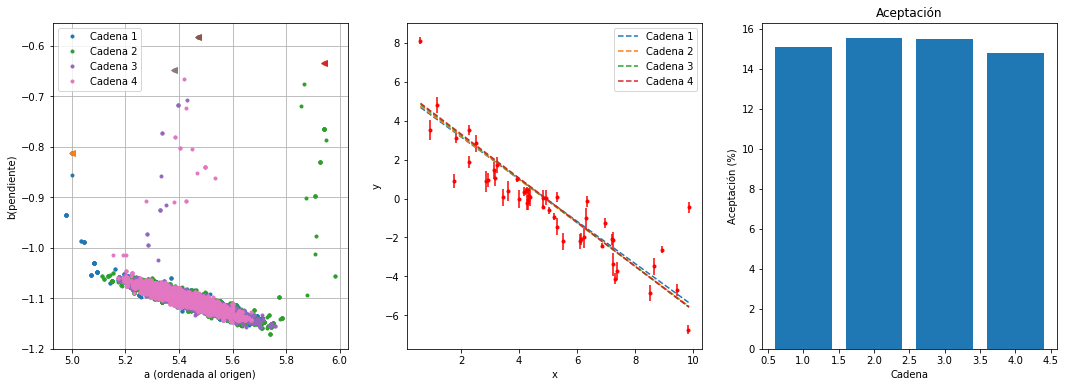

In [10]:
cam(matA,matB,t_acep)

Cadena: 1
Parámetro a: 5.4342892515214345 +/- 0.00198164949275031
Parámetro b: -1.1026079309034178 +/- 0.00038874342148892524
Tasa de aceptación 15.06 %
Cadena: 2
Parámetro a: 5.447669289177069 +/- 0.0019931864887580294
Parámetro b: -1.1039961818208295 +/- 0.0004507171362243534
Tasa de aceptación 15.52 %
Cadena: 3
Parámetro a: 5.443335570885408 +/- 0.001832124879408589
Parámetro b: -1.104068869556422 +/- 0.0004378274050099184
Tasa de aceptación 15.459999999999999 %
Cadena: 4
Parámetro a: 5.427641377325249 +/- 0.0018552045229204694
Parámetro b: -1.1016007775661916 +/- 0.0004209837899656034
Tasa de aceptación 14.77 %


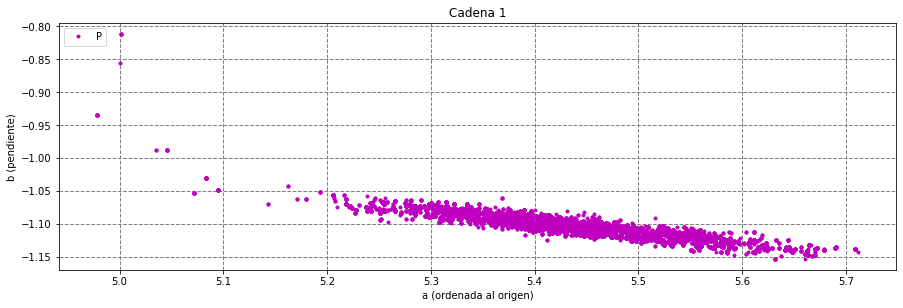

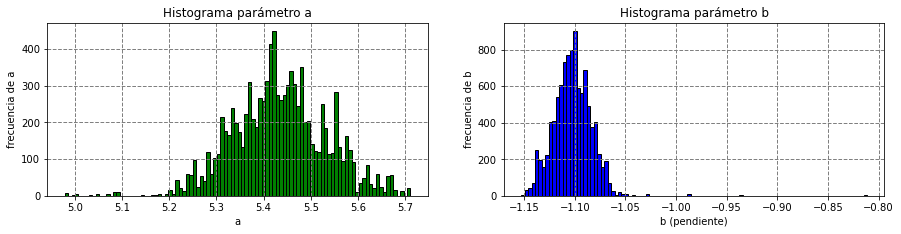

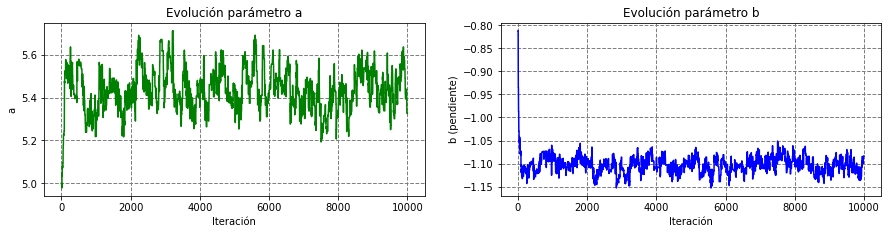

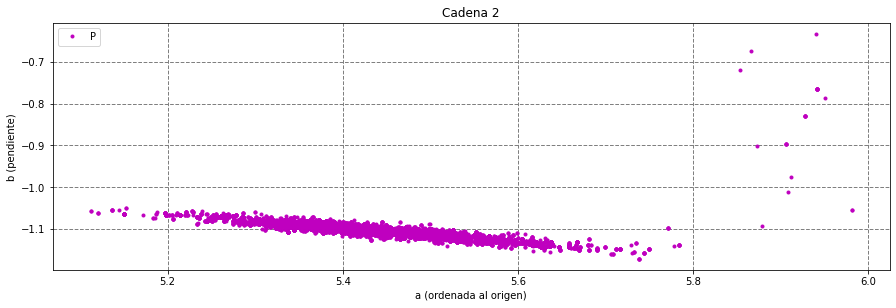

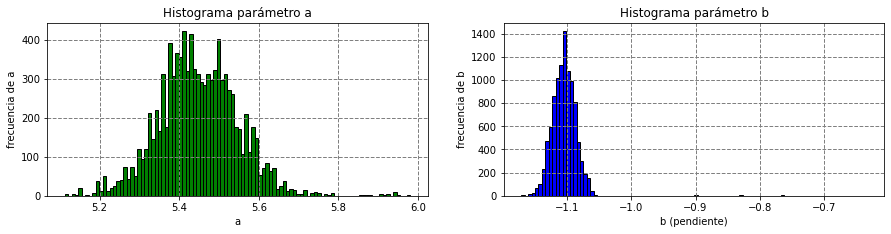

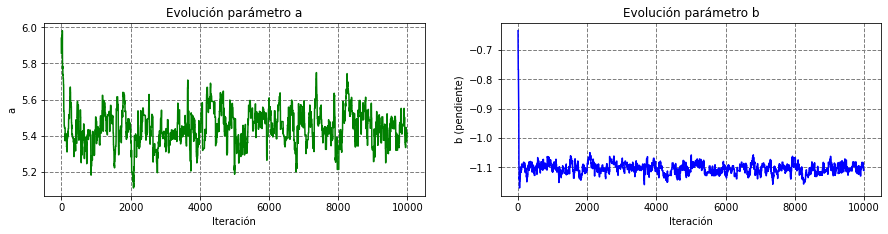

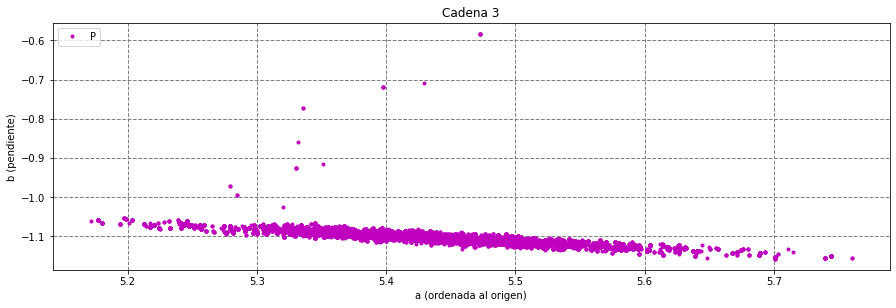

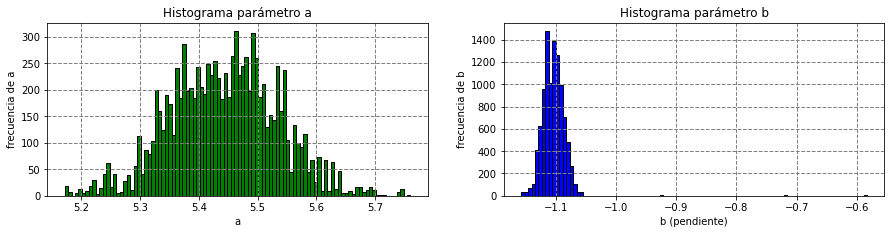

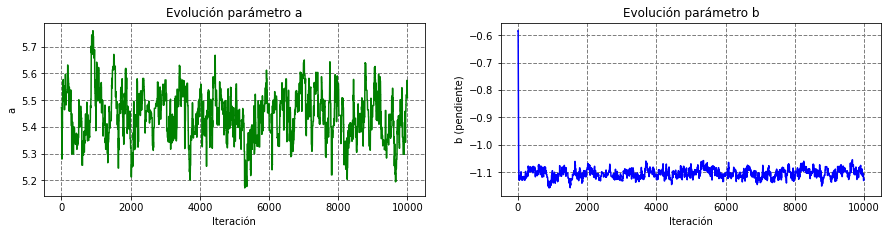

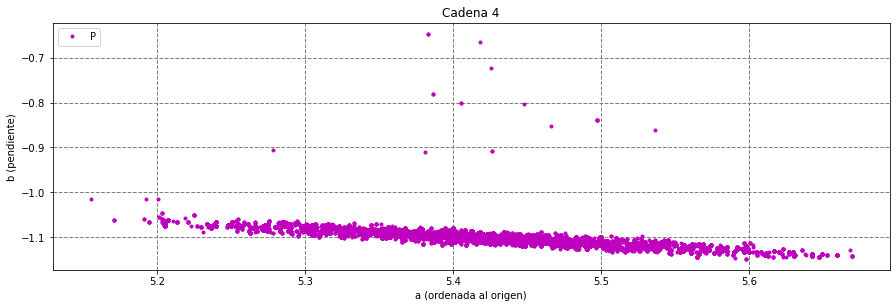

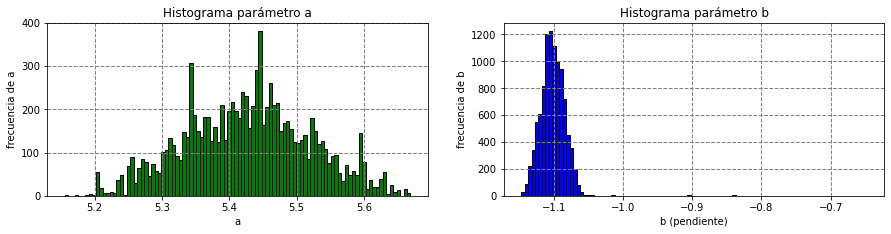

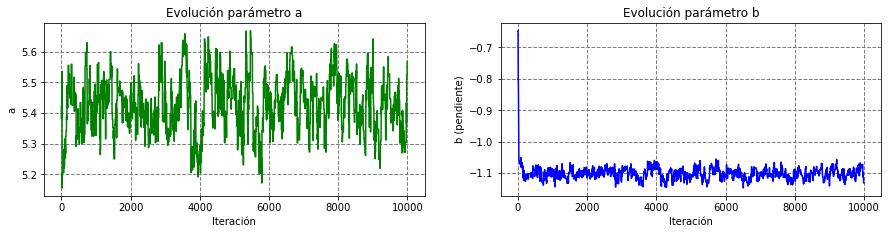

In [11]:
graf(matA,matB,t_acep)

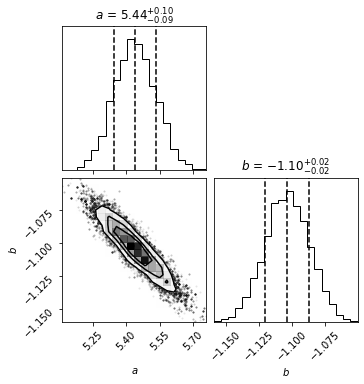

In [12]:
tri(matA,matB)